In [3]:
!pip3.10 install plotly --break-system-packages

  Using cached plotly-5.24.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached tenacity-9.0.0-py3-none-any.whl.metadata (1.2 kB)
Using cached plotly-5.24.1-py3-none-any.whl (19.1 MB)
Using cached tenacity-9.0.0-py3-none-any.whl (28 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


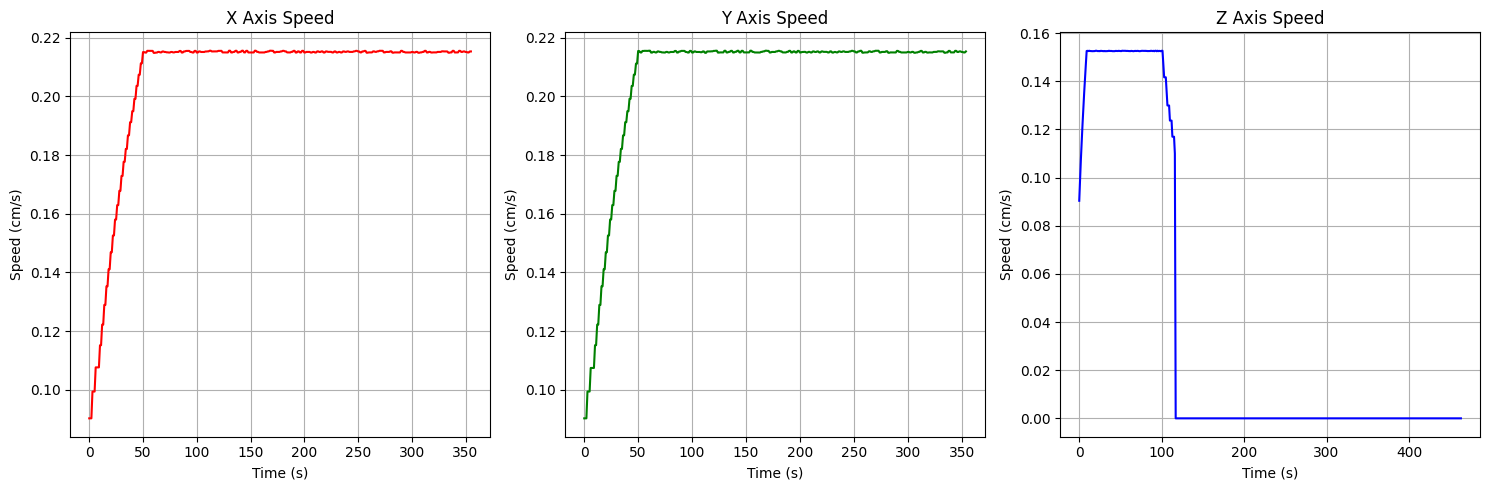

In [10]:
# Example of input.txt:
"""
Z1
15770132
X1
15782756
Y1
15798264
X1
15811036
X1
15839296
X1
15867560
Y1
15868084
X1
15895820
Z1
15910404
X1
15924072
X1
15952336
X1
15980588
X1
16008852
X1
16037120
"""

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

string = [l.strip('\n') for l in open('input.txt', 'r').readlines()]

# Parse coordinates, times and calculate speeds
coords = {}
current_coord = None
x_points, y_points, z_points = [], [], []
x_times, y_times, z_times = [], [], []
x_speeds, y_speeds, z_speeds = [], [], []
step_to_cm = 1/110.65  # Convert steps to cm

# Initialize first values 
x, y, z = 0, 0, 0

for i, line in enumerate(string):
    if line in ['X1', 'X0', 'Y1', 'Y0', 'Z1', 'Z0']:
        current_coord = line
    elif line[0].isdigit():
        time = int(line) / 1000000  # Convert microseconds to seconds
        # Convert steps to cm and handle direction
        if current_coord.startswith('X'):
            x += (1 if current_coord.endswith('1') else -1) * step_to_cm
            x_points.append(x)
            y_points.append(y)
            z_points.append(z)
            x_times.append(time)
            if len(x_times) > 1:
                dt = x_times[-1] - x_times[-2]
                speed = step_to_cm / dt if dt > 0 else 0
                x_speeds.append(speed)

            if len(y_times) > 1:
                dt = y_times[-1] - y_times[-2]
                speed = step_to_cm / dt if dt > 0 else 0
                y_speeds.append(speed)

            if len(z_times) > 1:
                dt = z_times[-1] - z_times[-2]
                speed = step_to_cm / dt if dt > 0 else 0
                z_speeds.append(speed)


        elif current_coord.startswith('Y'):
            y += (1 if current_coord.endswith('1') else -1) * step_to_cm
            y_points.append(y)
            x_points.append(x)
            z_points.append(z)
            y_times.append(time)
            if len(y_times) > 1:
                dt = y_times[-1] - y_times[-2]
                speed = step_to_cm / dt if dt > 0 else 0
                y_speeds.append(speed)
            
            if len(z_times) > 1:
                dt = z_times[-1] - z_times[-2]
                speed = step_to_cm / dt if dt > 0 else 0
                z_speeds.append(speed)

            if len(x_times) > 1:
                dt = x_times[-1] - x_times[-2]
                speed = step_to_cm / dt if dt > 0 else 0
                x_speeds.append(speed)

        elif current_coord.startswith('Z'):
            z += (1 if current_coord.endswith('1') else -1) * step_to_cm
            z_points.append(z)
            x_points.append(x)
            y_points.append(y)
            z_times.append(time)
            if len(z_times) > 1:
                dt = z_times[-1] - z_times[-2]
                speed = step_to_cm / dt if dt > 0 else 0
                z_speeds.append(speed)
            
            if len(x_times) > 1:
                dt = x_times[-1] - x_times[-2]
                speed = step_to_cm / dt if dt > 0 else 0
                x_speeds.append(speed)

            if len(y_times) > 1:
                dt = y_times[-1] - y_times[-2]
                speed = step_to_cm / dt if dt > 0 else 0
                y_speeds.append(speed)

# Create interactive 3D plot using plotly
fig_3d = go.Figure(data=[go.Scatter3d(
    x=x_points,
    y=y_points,
    z=z_points,
    mode='lines+markers',
    marker=dict(size=2),
    line=dict(width=2)
)])

fig_3d.update_layout(
    title='3D Trajectory',
    scene=dict(
        xaxis_title='X Position (cm)',
        yaxis_title='Y Position (cm)',
        zaxis_title='Z Position (cm)'
    ),
    width=800,
    height=800
)

fig_3d.show()

# Create speed plots
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(range(len(x_speeds)), x_speeds, 'r-', label='X Speed')
plt.xlabel('Time (s)')
plt.ylabel('Speed (cm/s)')
plt.title('X Axis Speed')
plt.grid(True)

plt.subplot(132)
plt.plot(range(len(y_speeds)), y_speeds, 'g-', label='Y Speed')
plt.xlabel('Time (s)')
plt.ylabel('Speed (cm/s)')
plt.title('Y Axis Speed')
plt.grid(True)

plt.subplot(133)
plt.plot(range(len(z_speeds)), z_speeds, 'b-', label='Z Speed')
plt.xlabel('Time (s)')
plt.ylabel('Speed (cm/s)')
plt.title('Z Axis Speed')
plt.grid(True)

plt.tight_layout()
plt.show()


In [3]:
len(x)

1200